In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
import xarray as xr
import numpy as np
import pop_tools 
# import ncar_jobqueue
# from dask.distributed import Client
import utils

import matplotlib.pyplot as plt
import cartopy
import cmocean
import cartopy.crs as ccrs
import cmocean
import matplotlib.path as mpath

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='04:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [3]:
#cluster.close()

In [4]:
cluster, client = get_ClusterClient()
cluster.scale(24) 
client

Client Scheduler: tcp://128.117.208.177:40021 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [5]:
ds_grid_x1 = pop_tools.get_grid('POP_gx1v7').isel(nlat=slice(0,55))
lons_x1=ds_grid_x1.TLONG
lats_x1=ds_grid_x1.TLAT
area_x1=ds_grid_x1.TAREA
area_m_x1=ds_grid_x1.TAREA * 1e-4
lons_norm_x1 = utils.normal_lons(lons_x1)

In [6]:
## based on CESM1-LE -- will redo!!
ds_siz_mask = xr.open_dataset('/glade/u/home/kristenk/antarc_marine_pred_work/TOE/SIZ_mask_1920-50-CESM2LE_15percentJJA.nc')
ds_siz_mask = ds_siz_mask.isel(nlat=slice(0,55))

In [7]:
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-LE-FEISTY'

files = sorted(glob(f'{path}/CESM2-LE-FEISTY-HIST-SSP370-cmip6-ensmem-????????_1850-2100.nc'))
        
ds_feisty_x1=xr.open_mfdataset(files,concat_dim="member_id", coords='minimal', compat="override", combine='nested')

In [8]:
files[24]

'/glade/campaign/cesm/development/bgcwg/projects/CESM2-LE-FEISTY/CESM2-LE-FEISTY-HIST-SSP370-cmip6-ensmem-1251.005_1850-2100.nc'

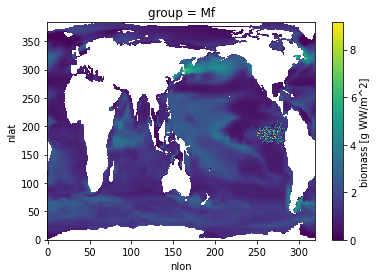

In [9]:
ds_feisty_x1.isel(member_id=24,time=0).biomass.sel(group='Mf').plot()

### Simplify FEISTY fish groups

In [10]:
ds_feisty_x1['total_forage'] = ds_feisty_x1.biomass.sel(group='Sf') + ds_feisty_x1.biomass.sel(group='Mf')
ds_feisty_x1['total_pelagic'] = ds_feisty_x1.biomass.sel(group='Sp') + ds_feisty_x1.biomass.sel(group='Mp') + ds_feisty_x1.biomass.sel(group='Lp')
ds_feisty_x1['total_demersal'] = ds_feisty_x1.biomass.sel(group='Sd') + ds_feisty_x1.biomass.sel(group='Md') + ds_feisty_x1.biomass.sel(group='Ld')
ds_feisty_x1['total_fish'] = ds_feisty_x1['total_forage'] + ds_feisty_x1['total_pelagic']  + ds_feisty_x1['total_demersal']

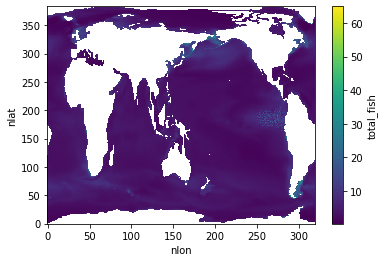

In [11]:
ds_feisty_x1['total_fish'].isel(member_id=24,time=0).plot()

In [12]:
ds_feisty_x1 = ds_feisty_x1.drop(['biomass','fish_yield','production'])

In [13]:
ds_feisty_x1['time'] = np.arange(1850,2101,1)

### Now make an ice obligate fish dataset

In [14]:
### read in seasonal averages of ice
file = '/glade/derecho/scratch/kristenk/ToE_saved_data/CESM2-LE-annual-mean-IFRAC.nc'
ds = xr.open_dataset(file)
ds = ds.isel(nlat=slice(0,55))

In [15]:
ds = ds.load()

In [16]:
ds=ds.isel(time=slice(0,250))

In [17]:
ds_feisty_x1 = ds_feisty_x1.isel(time=slice(0,250))
ds_feisty_x1 = ds_feisty_x1.isel(nlat=slice(0,55))
ds_feisty_x1

,Array,Chunk
Bytes,1.64 GiB,33.57 MiB
Shape,"(50, 250, 55, 320)","(1, 250, 55, 320)"
Count,450 Tasks,50 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,1.64 GiB,33.57 MiB
Shape,"(50, 250, 55, 320)","(1, 250, 55, 320)"
Count,550 Tasks,50 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [18]:
ds_feisty_x1['total_forage_ice'] = ds_feisty_x1['total_forage'] * ds.IFRAC
ds_feisty_x1['total_pelagic_ice'] = ds_feisty_x1['total_pelagic'] * ds.IFRAC
ds_feisty_x1['total_demersal_ice'] = ds_feisty_x1['total_demersal'] * ds.IFRAC
ds_feisty_x1['total_fish_ice'] = ds_feisty_x1['total_fish'] * ds.IFRAC

In [19]:
ds_feisty_x1 = ds_feisty_x1.load()

### Write out the total fish dataset so that I can use it elsewhere

In [20]:
# ds_out = xr.Dataset()
# ds_out['total_fish'] = ds_feisty_x1['total_fish']
# ds_out['total_fish_ice'] = ds_feisty_x1['total_fish_ice']

In [22]:
fileout = '/glade/derecho/scratch/kristenk/ToE_saved_data/FEISTY_ann_tot_fish.nc'
ds_feisty_x1.to_netcdf(fileout, mode='w')

#ds_out = xr.open_dataset('/glade/derecho/scratch/kristenk/ToE_saved_data/FEISTY_ann_tot_fish.nc')

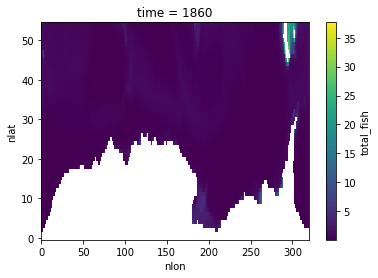

In [26]:
ds_feisty_x1['total_fish'].isel(member_id=24,time=10).plot()

# Some prelim analysis

### Make a map of fish changes, 1950 to 2100

In [9]:
#demersal_ice_changes.plot(vmin=-5,vmax=5,cmap='bwr')

In [10]:
ds_start = ds_out.isel(time=slice(70,100)).mean(dim=('time','member_id')).load()

In [11]:
ds_end = ds_out.isel(time=slice(220,249)).mean(dim=('time','member_id')).load()

### Put all these maps together to summarize changes in fish

### Changes in total fish

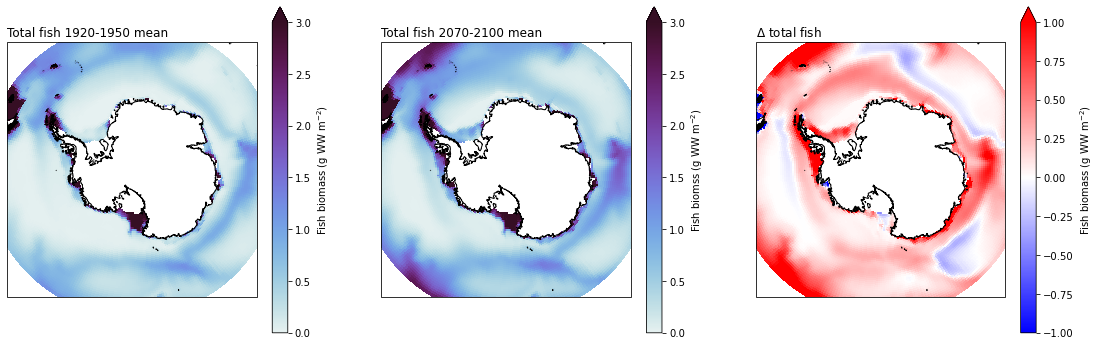

In [12]:
cmap = cmocean.cm.dense
cmap_diff = 'bwr'
extent = [-180, 180, -90, -55]

fig = plt.figure(figsize=(19,6))

############################################################################## start period (1920-1950)


ax = fig.add_subplot(1,3,1, projection=ccrs.SouthPolarStereo())
ax.set_extent(extent, ccrs.PlateCarree())
ax.set_title('Total fish 1920-1950 mean', loc='left')

lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_start.total_fish)
pc=ax.pcolormesh(lon, lat, 
                 field,
                 vmin=0, vmax=3, 
                 cmap=cmap,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)

fig.colorbar(pc,extend='max', label='Fish biomass (g WW m$^{-2}$)');

###############################################

ax = fig.add_subplot(1,3,2, projection=ccrs.SouthPolarStereo())
ax.set_extent(extent, ccrs.PlateCarree())
ax.set_title('Total fish 2070-2100 mean', loc='left')

lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_end.total_fish)
pc=ax.pcolormesh(lon, lat, 
                 field,
                 vmin=0, vmax=3, 
                 cmap=cmap,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)

fig.colorbar(pc,extend='max', label='Fish biomss (g WW m$^{-2}$)');
############################################################################## diff = end period (2070-2100) - start period (1920-1950)





ax = fig.add_subplot(1,3,3, projection=ccrs.SouthPolarStereo())
ax.set_extent(extent, ccrs.PlateCarree())
ax.set_title('${\Delta}$ total fish', loc='left')

lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_end.total_fish-ds_start.total_fish)
pc=ax.pcolormesh(lon, lat, 
                 field,
                 vmin=-1, vmax=1, 
                 cmap=cmap_diff,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)

fig.colorbar(pc,extend='max', label='Fish biomass (g WW m$^{-2}$)');

###############################################


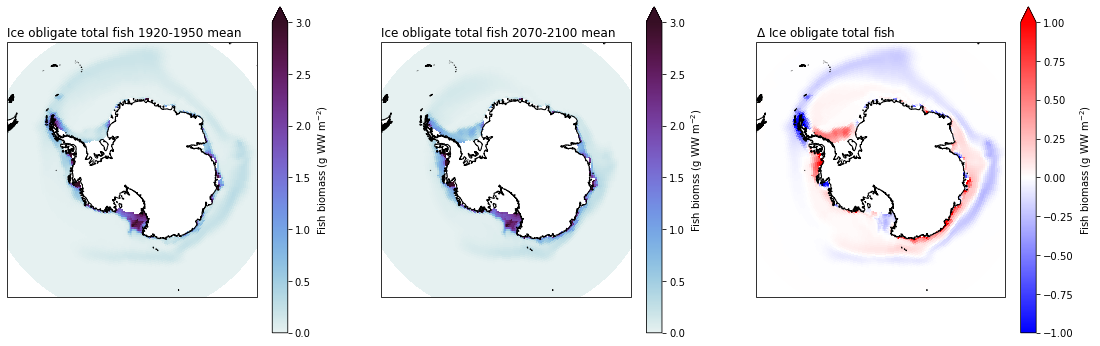

In [13]:
cmap = cmocean.cm.dense
cmap_diff = 'bwr'
extent = [-180, 180, -90, -55]

fig = plt.figure(figsize=(19,6))

############################################################################## start period (1920-1950)


ax = fig.add_subplot(1,3,1, projection=ccrs.SouthPolarStereo())
ax.set_extent(extent, ccrs.PlateCarree())
ax.set_title('Ice obligate total fish 1920-1950 mean', loc='left')

lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_start.total_fish_ice)
pc=ax.pcolormesh(lon, lat, 
                 field,
                 vmin=0, vmax=3, 
                 cmap=cmap,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)

fig.colorbar(pc,extend='max', label='Fish biomass (g WW m$^{-2}$)');

###############################################

ax = fig.add_subplot(1,3,2, projection=ccrs.SouthPolarStereo())
ax.set_extent(extent, ccrs.PlateCarree())
ax.set_title('Ice obligate total fish 2070-2100 mean', loc='left')

lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_end.total_fish_ice)
pc=ax.pcolormesh(lon, lat, 
                 field,
                 vmin=0, vmax=3, 
                 cmap=cmap,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)

fig.colorbar(pc,extend='max', label='Fish biomss (g WW m$^{-2}$)');
############################################################################## diff = end period (2070-2100) - start period (1920-1950)





ax = fig.add_subplot(1,3,3, projection=ccrs.SouthPolarStereo())
ax.set_extent(extent, ccrs.PlateCarree())
ax.set_title('${\Delta}$ Ice obligate total fish', loc='left')

lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_end.total_fish_ice-ds_start.total_fish_ice)
pc=ax.pcolormesh(lon, lat, 
                 field,
                 vmin=-1, vmax=1, 
                 cmap=cmap_diff,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=1)

fig.colorbar(pc,extend='max', label='Fish biomass (g WW m$^{-2}$)');

###############################################


### Let's make a number of masks and the estimate ToE in each of those

In [14]:
ones_x1 = np.full((55,320),1,dtype=int)
ones_x1 = xr.DataArray(ones_x1,dims=('nlat','nlon'))
ones_x1 = ones_x1.where(ds_grid_x1.REGION_MASK>0)

In [15]:
### Antarctic peninsula tip
box1_latmin = -64
box1_latmax = -62
box1_lonmin = -63.
box1_lonmax = -53.

### East Ant north
box2_latmin = -70
box2_latmax = -65
box2_lonmin = 12.
box2_lonmax = 30.


### Weddell sea increase
box3_latmin = -76
box3_latmax = -73
box3_lonmin = -48.
box3_lonmax = -35.

### Terre Adelie
box4_latmin = -67
box4_latmax = -65
box4_lonmin = 136.
box4_lonmax = 142.


In [16]:
#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

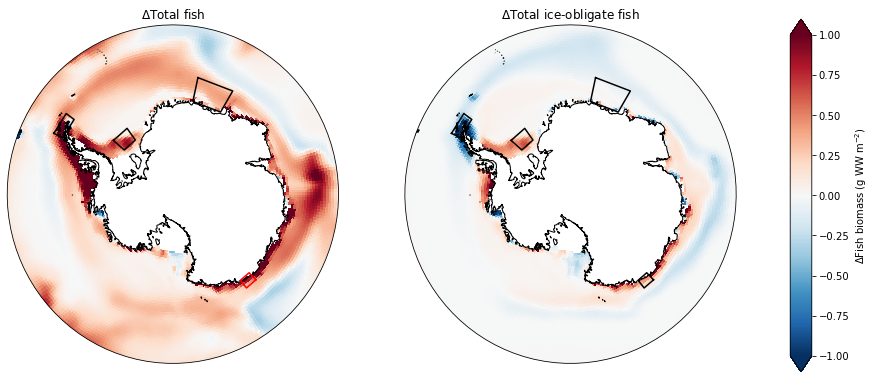

In [17]:
fig = plt.figure(figsize=(15,7))

diff_cmap='RdBu_r'
ice_lev = [0.15,0.85]
ice_color = 'black'


############################
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax.set_title('${\Delta}$Total fish')
ax.coastlines('10m',linewidth=1)
lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_end.total_fish-ds_start.total_fish)

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap=diff_cmap,
                   vmin=-1,vmax=1
                  )
ax.set_boundary(circle, transform=ax.transAxes)
box_color='black'
# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())


lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box4_lonmin,box4_lonmax,box4_lonmax,box4_lonmin,box4_lonmin]
lat_pts = [box4_latmax,box4_latmax,box4_latmin,box4_latmin,box4_latmax]
ax.plot(lon_pts, lat_pts, color="red", linewidth=1.5,transform=ccrs.PlateCarree())


############################
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax.set_title('${\Delta}$Total ice-obligate fish')
ax.coastlines('10m',linewidth=1)
lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_end.total_fish_ice-ds_start.total_fish_ice)

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap=diff_cmap,
                   vmin=-1,vmax=1
                  )
ax.set_boundary(circle, transform=ax.transAxes)
box_color='black'
# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())


lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box4_lonmin,box4_lonmax,box4_lonmax,box4_lonmin,box4_lonmin]
lat_pts = [box4_latmax,box4_latmax,box4_latmin,box4_latmin,box4_latmax]
ax.plot(lon_pts, lat_pts, color="black", linewidth=1.5,transform=ccrs.PlateCarree())
######################################
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])

cbar1 = fig.colorbar(pc1, cax=cbar_ax, extend='both',label='${\Delta}$Fish biomass (g WW m$^{-2}$)')


In [18]:
mask1 = ones_x1.where(lats_x1<box1_latmax).where(lats_x1>box1_latmin).where(lons_norm_x1<box1_lonmax).where(lons_norm_x1>box1_lonmin)
mask2 = ones_x1.where(lats_x1<box2_latmax).where(lats_x1>box2_latmin).where(lons_norm_x1<box2_lonmax).where(lons_norm_x1>box2_lonmin)
mask3 = ones_x1.where(lats_x1<box3_latmax).where(lats_x1>box3_latmin).where(lons_norm_x1<box3_lonmax).where(lons_norm_x1>box3_lonmin)
mask4 = ones_x1.where(lats_x1<box4_latmax).where(lats_x1>box4_latmin).where(lons_norm_x1<box4_lonmax).where(lons_norm_x1>box4_lonmin)

In [19]:
ts_AP = xr.Dataset()
ts_EAnt = xr.Dataset()
ts_Wedd = xr.Dataset()
ts_Adelie = xr.Dataset()


for v in ['total_fish','total_fish_ice']:
        
        
    ######### first do AP

    masked_area = area_x1.where(mask1==1)
    
    masked_fosi = ds_out[v].where(mask1==1)
    masked_area['nlat'] = mask1.nlat
    masked_area['nlon'] = mask1.nlon
    
    ts_AP[v] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
    ######### do East Antarctica
    
    masked_area = area_x1.where(mask2==1)
    masked_area['nlat'] = mask2.nlat
    masked_area['nlon'] = mask2.nlon
    
    masked_fosi = ds_out[v].where(mask2==1)
    
    ts_EAnt[v] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
    
    #########  Weddell
    
    masked_area = area_x1.where(mask3==1)
    masked_area['nlat'] = mask3.nlat
    masked_area['nlon'] = mask3.nlon
    
    masked_fosi = ds_out[v].where(mask3==1)
    
    ts_Wedd[v] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

    #########  Terre Adelie
    
    masked_area = area_x1.where(mask4==1)
    masked_area['nlat'] = mask4.nlat
    masked_area['nlon'] = mask4.nlon
    
    masked_fosi = ds_out[v].where(mask4==1)
    
    ts_Adelie[v] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
    

In [20]:
%%time

ts_EAnt = ts_EAnt.load()
print('loaded EAnt')
ts_Wedd = ts_Wedd.load()
print('loaded Wedd')
ts_AP = ts_AP.load()
print('loaded AP')
ts_Adelie = ts_Adelie.load()
print('loaded AP')

loaded EAnt
loaded Wedd
loaded AP
loaded AP
CPU times: user 494 µs, sys: 512 µs, total: 1.01 ms
Wall time: 1.02 ms


In [21]:
ts_AP

<xarray.Dataset>
Dimensions:         (member_id: 50, time: 250)
Coordinates:
  * time            (time) int64 1850 1851 1852 1853 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id
Data variables:
    total_fish      (member_id, time) float64 8.303 6.45 4.736 ... 4.898 4.839
    total_fish_ice  (member_id, time) float64 2.566 2.621 1.73 ... 0.1627 0.1131

In [22]:
years2 = np.arange(1920,2100,1)

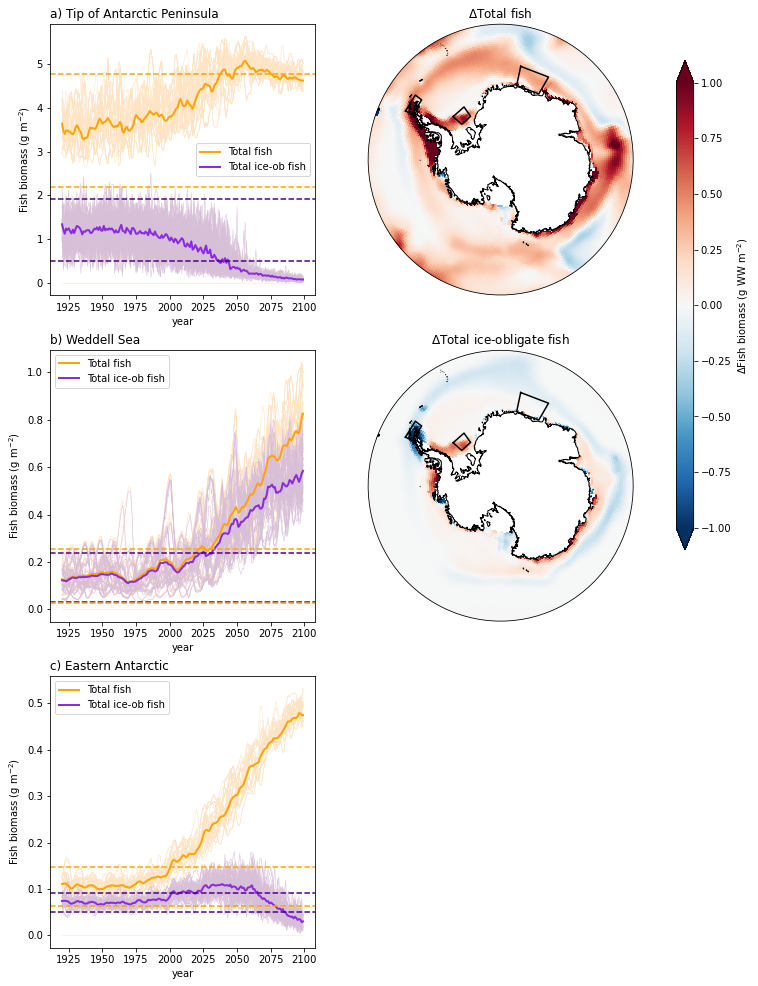

In [23]:
fig = plt.figure(figsize=(12,17))

######################################################

ax = fig.add_subplot(3,2,1)

ax.set_title('a) Tip of Antarctic Peninsula',loc='left')

for mem in np.arange(0,50,1):
    ax.plot(years2, ts_AP['total_fish'].isel(member_id=mem,time=slice(70,250)), color='bisque', linewidth=0.5)
    

for mem in np.arange(0,50,1):
    ax.plot(years2, ts_AP['total_fish_ice'].isel(member_id=mem,time=slice(70,250)), color='thistle', linewidth=0.5)
     
## plot means

ax.plot(years2, ts_AP['total_fish'].mean(dim='member_id').isel(time=slice(70,250)), color='orange', linewidth=2, label='Total fish')
ax.plot(years2, ts_AP['total_fish_ice'].mean(dim='member_id').isel(time=slice(70,250)), color='blueviolet', linewidth=2, label='Total ice-ob fish')

mean = ts_AP['total_fish_ice'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_AP['total_fish_ice'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='indigo')
ax.axhline(mean+2*std, color='indigo',linestyle='--')
ax.axhline(mean-2*std, color='indigo',linestyle='--')

mean = ts_AP['total_fish'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_AP['total_fish'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='orange')
ax.axhline(mean+2*std, color='orange',linestyle='--')
ax.axhline(mean-2*std, color='orange',linestyle='--')

ax.set(xlabel='year',ylabel='Fish biomass (g m$^{-2}$)');
#ax.set_ylim(0,1.6)
ax.legend()


######################################################

ax = fig.add_subplot(3,2,3)

ax.set_title('b) Weddell Sea',loc='left')

for mem in np.arange(0,50,1):
    ax.plot(years2, ts_Wedd['total_fish'].isel(member_id=mem,time=slice(70,250)), color='bisque', linewidth=0.5)
    

for mem in np.arange(0,50,1):
    ax.plot(years2, ts_Wedd['total_fish_ice'].isel(member_id=mem,time=slice(70,250)), color='thistle', linewidth=0.5)
     
## plot means

ax.plot(years2, ts_Wedd['total_fish'].mean(dim='member_id').isel(time=slice(70,250)), color='orange', linewidth=2, label='Total fish')
ax.plot(years2, ts_Wedd['total_fish_ice'].mean(dim='member_id').isel(time=slice(70,250)), color='blueviolet', linewidth=2, label='Total ice-ob fish')

mean = ts_Wedd['total_fish_ice'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_Wedd['total_fish_ice'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='indigo')
ax.axhline(mean+2*std, color='indigo',linestyle='--')
ax.axhline(mean-2*std, color='indigo',linestyle='--')

mean = ts_Wedd['total_fish'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_Wedd['total_fish'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='orange')
ax.axhline(mean+2*std, color='orange',linestyle='--')
ax.axhline(mean-2*std, color='orange',linestyle='--')

ax.set(xlabel='year',ylabel='Fish biomass (g m$^{-2}$)');
#ax.set_ylim(0,1.6)
ax.legend()



######################################################

ax = fig.add_subplot(3,2,5)

ax.set_title('c) Eastern Antarctic',loc='left')

for mem in np.arange(0,50,1):
    ax.plot(years2, ts_EAnt['total_fish'].isel(member_id=mem,time=slice(70,250)), color='bisque', linewidth=0.5)
    

for mem in np.arange(0,50,1):
    ax.plot(years2, ts_EAnt['total_fish_ice'].isel(member_id=mem,time=slice(70,250)), color='thistle', linewidth=0.5)
     
## plot means

ax.plot(years2, ts_EAnt['total_fish'].mean(dim='member_id').isel(time=slice(70,250)), color='orange', linewidth=2, label='Total fish')
ax.plot(years2, ts_EAnt['total_fish_ice'].mean(dim='member_id').isel(time=slice(70,250)), color='blueviolet', linewidth=2, label='Total ice-ob fish')

mean = ts_EAnt['total_fish_ice'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_EAnt['total_fish_ice'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='indigo')
ax.axhline(mean+2*std, color='indigo',linestyle='--')
ax.axhline(mean-2*std, color='indigo',linestyle='--')

mean = ts_EAnt['total_fish'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_EAnt['total_fish'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='orange')
ax.axhline(mean+2*std, color='orange',linestyle='--')
ax.axhline(mean-2*std, color='orange',linestyle='--')

ax.set(xlabel='year',ylabel='Fish biomass (g m$^{-2}$)');
#ax.set_ylim(0,1.6)
ax.legend()




############################
ax = fig.add_subplot(3,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax.set_title('${\Delta}$Total fish')
ax.coastlines('10m',linewidth=1)
lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_end.total_fish-ds_start.total_fish)

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap=diff_cmap,
                   vmin=-1,vmax=1
                  )
ax.set_boundary(circle, transform=ax.transAxes)
box_color='black'
# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())


lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())



############################
ax = fig.add_subplot(3,2,4, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax.set_title('${\Delta}$Total ice-obligate fish')
ax.coastlines('10m',linewidth=1)
lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_end.total_fish_ice-ds_start.total_fish_ice)

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap=diff_cmap,
                   vmin=-1,vmax=1
                  )
ax.set_boundary(circle, transform=ax.transAxes)
box_color='black'
# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())


lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())


######################################
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.45, 0.02, 0.4])

cbar1 = fig.colorbar(pc1, cax=cbar_ax, extend='both',label='${\Delta}$Fish biomass (g WW m$^{-2}$)')




#fig.savefig('/glade/work/kristenk/figs/Fish_shelf_offshelf_lineplots.png', bbox_inches='tight', dpi=300, format='png');


In [25]:
import matplotlib.gridspec as gridspec

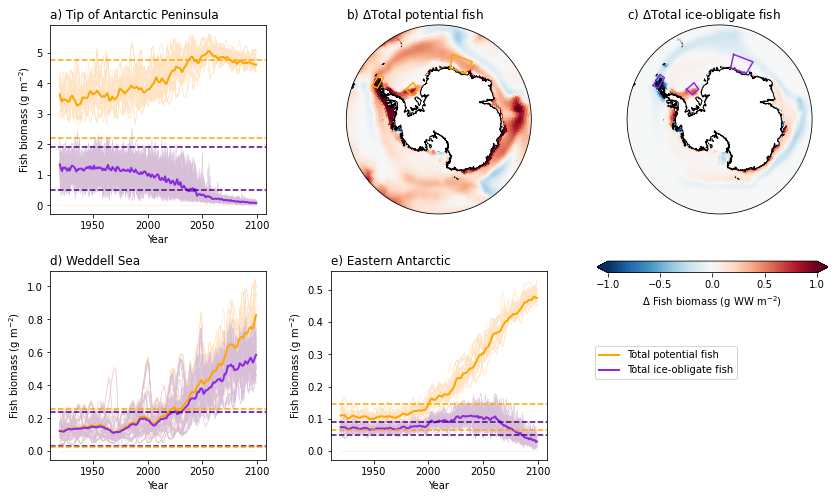

In [26]:
fig = plt.figure(figsize=(16,8))

######################################################

ax = fig.add_subplot(2,3,1)

ax.set_title('a) Tip of Antarctic Peninsula',loc='left')

for mem in np.arange(0,50,1):
    ax.plot(years2, ts_AP['total_fish'].isel(member_id=mem,time=slice(70,250)), color='bisque', linewidth=0.5)
    

for mem in np.arange(0,50,1):
    ax.plot(years2, ts_AP['total_fish_ice'].isel(member_id=mem,time=slice(70,250)), color='thistle', linewidth=0.5)
     
## plot means

ax.plot(years2, ts_AP['total_fish'].mean(dim='member_id').isel(time=slice(70,250)), color='orange', linewidth=2, label='Total fish')
ax.plot(years2, ts_AP['total_fish_ice'].mean(dim='member_id').isel(time=slice(70,250)), color='blueviolet', linewidth=2, label='Total ice-ob fish')

mean = ts_AP['total_fish_ice'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_AP['total_fish_ice'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='indigo')
ax.axhline(mean+2*std, color='indigo',linestyle='--')
ax.axhline(mean-2*std, color='indigo',linestyle='--')

mean = ts_AP['total_fish'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_AP['total_fish'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='orange')
ax.axhline(mean+2*std, color='orange',linestyle='--')
ax.axhline(mean-2*std, color='orange',linestyle='--')

ax.set(xlabel='Year',ylabel='Fish biomass (g m$^{-2}$)');
#ax.set_ylim(0,1.6)
#ax.legend()


######################################################

ax = fig.add_subplot(2,3,4)

ax.set_title('d) Weddell Sea',loc='left')

for mem in np.arange(0,50,1):
    ax.plot(years2, ts_Wedd['total_fish'].isel(member_id=mem,time=slice(70,250)), color='bisque', linewidth=0.5)
    

for mem in np.arange(0,50,1):
    ax.plot(years2, ts_Wedd['total_fish_ice'].isel(member_id=mem,time=slice(70,250)), color='thistle', linewidth=0.5)
     
## plot means

ax.plot(years2, ts_Wedd['total_fish'].mean(dim='member_id').isel(time=slice(70,250)), color='orange', linewidth=2, label='Total fish')
ax.plot(years2, ts_Wedd['total_fish_ice'].mean(dim='member_id').isel(time=slice(70,250)), color='blueviolet', linewidth=2, label='Total ice-ob fish')

mean = ts_Wedd['total_fish_ice'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_Wedd['total_fish_ice'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='indigo')
ax.axhline(mean+2*std, color='indigo',linestyle='--')
ax.axhline(mean-2*std, color='indigo',linestyle='--')

mean = ts_Wedd['total_fish'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_Wedd['total_fish'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='orange')
ax.axhline(mean+2*std, color='orange',linestyle='--')
ax.axhline(mean-2*std, color='orange',linestyle='--')

ax.set(xlabel='Year',ylabel='Fish biomass (g m$^{-2}$)');
#ax.set_ylim(0,1.6)
#ax.legend()



######################################################

ax = fig.add_subplot(2,3,5)

ax.set_title('e) Eastern Antarctic',loc='left')

for mem in np.arange(0,50,1):
    ax.plot(years2, ts_EAnt['total_fish'].isel(member_id=mem,time=slice(70,250)), color='bisque', linewidth=0.5)
    

for mem in np.arange(0,50,1):
    ax.plot(years2, ts_EAnt['total_fish_ice'].isel(member_id=mem,time=slice(70,250)), color='thistle', linewidth=0.5)
     
## plot means

ax.plot(years2, ts_EAnt['total_fish'].mean(dim='member_id').isel(time=slice(70,250)), color='orange', linewidth=2, label='Total potential fish')
ax.plot(years2, ts_EAnt['total_fish_ice'].mean(dim='member_id').isel(time=slice(70,250)), color='blueviolet', linewidth=2, label='Total ice-obligate fish')

mean = ts_EAnt['total_fish_ice'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_EAnt['total_fish_ice'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='indigo')
ax.axhline(mean+2*std, color='indigo',linestyle='--')
ax.axhline(mean-2*std, color='indigo',linestyle='--')

mean = ts_EAnt['total_fish'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_EAnt['total_fish'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='orange')
ax.axhline(mean+2*std, color='orange',linestyle='--')
ax.axhline(mean-2*std, color='orange',linestyle='--')

ax.set(xlabel='Year',ylabel='Fish biomass (g m$^{-2}$)');
#ax.set_ylim(0,1.6)
ax.legend(bbox_to_anchor=(1.2, 0.4), loc='lower left')




############################
ax = fig.add_subplot(2,3,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax.set_title('b) ${\Delta}$Total potential fish',loc='left')
ax.coastlines('10m',linewidth=1)
lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_end.total_fish-ds_start.total_fish)

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap=diff_cmap,
                   vmin=-1,vmax=1
                  )
ax.set_boundary(circle, transform=ax.transAxes)
box_color='orange'
# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())


lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())



############################
ax = fig.add_subplot(2,3,3, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax.set_title('c) ${\Delta}$Total ice-obligate fish', loc='left')
ax.coastlines('10m',linewidth=1)
lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_end.total_fish_ice-ds_start.total_fish_ice)

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap=diff_cmap,
                   vmin=-1,vmax=1
                  )
ax.set_boundary(circle, transform=ax.transAxes)
box_color='blueviolet'
# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())


lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())


######################################
fig.subplots_adjust(right=0.8, wspace=0.3, hspace=0.3)
cbar_ax = fig.add_axes([0.6, 0.45, 0.2, 0.02])
cbar1 = fig.colorbar(pc1, cax=cbar_ax, extend='both',label='${\Delta}$ Fish biomass (g WW m$^{-2}$)', orientation='horizontal')




fig.savefig('/glade/work/kristenk/figs/Figure_fish_changes.png', bbox_inches='tight', dpi=300, format='png');


In [27]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

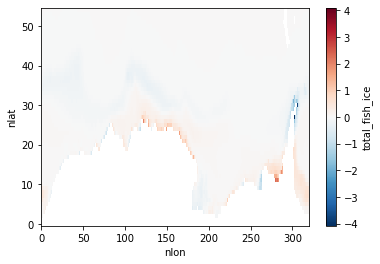

In [28]:
test = ds_end.total_fish_ice-ds_start.total_fish_ice
test.plot()

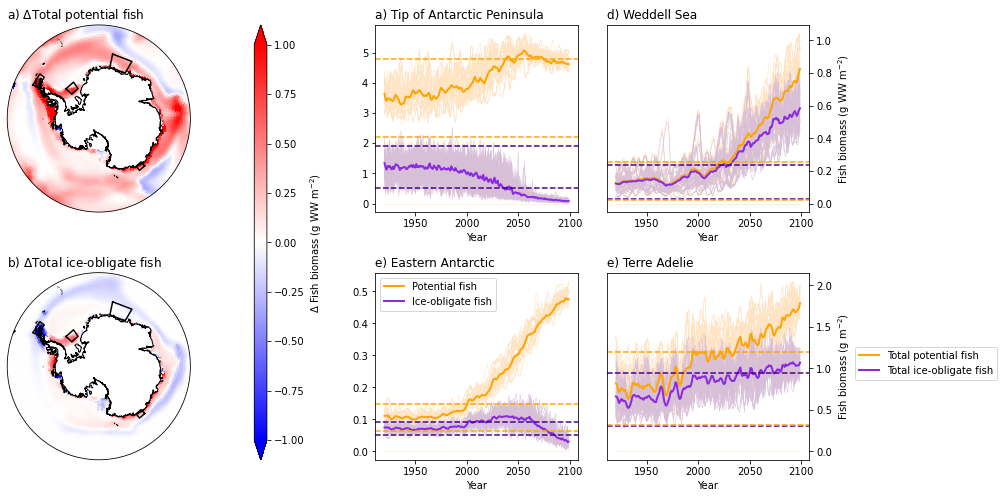

In [29]:
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(nrows=3, ncols=5, width_ratios=(1, 0.05, 0.2, 0.8, 0.8),height_ratios=(1,0.05,1))

prj =ccrs.SouthPolarStereo()

ax_map_tot = plt.subplot(gs[0, 0], projection=prj)
ax_map_if = plt.subplot(gs[2, 0], projection=prj)
ax_cb = plt.subplot(gs[0:3, 1])

ax_AP = plt.subplot(gs[0, 3])
ax_Wedd = plt.subplot(gs[0, 4])
ax_EAnt = plt.subplot(gs[2, 3])
ax_Adelie = plt.subplot(gs[2, 4])

box_color='black'
diff_cmap='bwr'
######################################################

ax_map_tot.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map_tot.set_title('a) ${\Delta}$Total potential fish',loc='left')
ax_map_tot.coastlines('10m',linewidth=1)
lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_end.total_fish-ds_start.total_fish)

pc1 = ax_map_tot.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap=diff_cmap,
                   vmin=-1,vmax=1
                  )
ax_map_tot.set_boundary(circle, transform=ax_map_tot.transAxes)

# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax_map_tot.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax_map_tot.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())


lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax_map_tot.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box4_lonmin,box4_lonmax,box4_lonmax,box4_lonmin,box4_lonmin]
lat_pts = [box4_latmax,box4_latmax,box4_latmin,box4_latmin,box4_latmax]
ax_map_tot.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

# ############################

ax_map_if.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ax_map_if.set_title('b) ${\Delta}$Total ice-obligate fish', loc='left')
ax_map_if.coastlines('10m',linewidth=1)
lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ds_end.total_fish_ice-ds_start.total_fish_ice)

pc1 = ax_map_if.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap=diff_cmap,
                   vmin=-1,vmax=1
                  )
ax_map_if.set_boundary(circle, transform=ax_map_if.transAxes)

# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax_map_if.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax_map_if.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())


lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax_map_if.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box4_lonmin,box4_lonmax,box4_lonmax,box4_lonmin,box4_lonmin]
lat_pts = [box4_latmax,box4_latmax,box4_latmin,box4_latmin,box4_latmax]
ax_map_if.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

######################################

cbar1 = fig.colorbar(pc1, cax=ax_cb, extend='both',label='${\Delta}$ Fish biomass (g WW m$^{-2}$)')
#ax_cb.text(1,0.1,'${\Delta}$ Fish biomass (g WW m$^{-2}$)', orientation='vertical')


#######################################

ax_AP.set_title('a) Tip of Antarctic Peninsula',loc='left')

for mem in np.arange(0,50,1):
    ax_AP.plot(years2, ts_AP['total_fish'].isel(member_id=mem,time=slice(70,250)), color='bisque', linewidth=0.5)
    

for mem in np.arange(0,50,1):
    ax_AP.plot(years2, ts_AP['total_fish_ice'].isel(member_id=mem,time=slice(70,250)), color='thistle', linewidth=0.5)
     
## plot means

ax_AP.plot(years2, ts_AP['total_fish'].mean(dim='member_id').isel(time=slice(70,250)), color='orange', linewidth=2, label='Total fish')
ax_AP.plot(years2, ts_AP['total_fish_ice'].mean(dim='member_id').isel(time=slice(70,250)), color='blueviolet', linewidth=2, label='Total ice-ob fish')

mean = ts_AP['total_fish_ice'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_AP['total_fish_ice'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='indigo')
ax_AP.axhline(mean+2*std, color='indigo',linestyle='--')
ax_AP.axhline(mean-2*std, color='indigo',linestyle='--')

mean = ts_AP['total_fish'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_AP['total_fish'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='orange')
ax_AP.axhline(mean+2*std, color='orange',linestyle='--')
ax_AP.axhline(mean-2*std, color='orange',linestyle='--')

ax_AP.set(xlabel='Year') #,ylabel='Fish biomass (g m$^{-2}$)');
#ax.set_ylim(0,1.6)
#ax.legend()


# ######################################################

ax_Wedd.set_title('d) Weddell Sea',loc='left')

for mem in np.arange(0,50,1):
    ax_Wedd.plot(years2, ts_Wedd['total_fish'].isel(member_id=mem,time=slice(70,250)), color='bisque', linewidth=0.5)
    

for mem in np.arange(0,50,1):
    ax_Wedd.plot(years2, ts_Wedd['total_fish_ice'].isel(member_id=mem,time=slice(70,250)), color='thistle', linewidth=0.5)
     
## plot means

ax_Wedd.plot(years2, ts_Wedd['total_fish'].mean(dim='member_id').isel(time=slice(70,250)), color='orange', linewidth=2, label='Total fish')
ax_Wedd.plot(years2, ts_Wedd['total_fish_ice'].mean(dim='member_id').isel(time=slice(70,250)), color='blueviolet', linewidth=2, label='Total ice-ob fish')

mean = ts_Wedd['total_fish_ice'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_Wedd['total_fish_ice'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='indigo')
ax_Wedd.axhline(mean+2*std, color='indigo',linestyle='--')
ax_Wedd.axhline(mean-2*std, color='indigo',linestyle='--')

mean = ts_Wedd['total_fish'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_Wedd['total_fish'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='orange')
ax_Wedd.axhline(mean+2*std, color='orange',linestyle='--')
ax_Wedd.axhline(mean-2*std, color='orange',linestyle='--')

ax_Wedd.set(xlabel='Year',ylabel='Fish biomass (g WW m$^{-2}$)');
#ax.set_ylim(0,1.6)
#ax.legend()
ax_Wedd.tick_params(top=False, labeltop=False, 
               bottom=True, labelbottom=True, 
               right=True, labelright=True,
               left=False, labelleft=False)
ax_Wedd.yaxis.set_label_position("right")
######################################################

ax_EAnt.set_title('e) Eastern Antarctic',loc='left')

for mem in np.arange(0,50,1):
    ax_EAnt.plot(years2, ts_EAnt['total_fish'].isel(member_id=mem,time=slice(70,250)), color='bisque', linewidth=0.5)
    

for mem in np.arange(0,50,1):
    ax_EAnt.plot(years2, ts_EAnt['total_fish_ice'].isel(member_id=mem,time=slice(70,250)), color='thistle', linewidth=0.5)
     
## plot means

ax_EAnt.plot(years2, ts_EAnt['total_fish'].mean(dim='member_id').isel(time=slice(70,250)), color='orange', linewidth=2, label='Potential fish')
ax_EAnt.plot(years2, ts_EAnt['total_fish_ice'].mean(dim='member_id').isel(time=slice(70,250)), color='blueviolet', linewidth=2, label='Ice-obligate fish')

mean = ts_EAnt['total_fish_ice'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_EAnt['total_fish_ice'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='indigo')
ax_EAnt.axhline(mean+2*std, color='indigo',linestyle='--')
ax_EAnt.axhline(mean-2*std, color='indigo',linestyle='--')

mean = ts_EAnt['total_fish'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_EAnt['total_fish'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='orange')
ax_EAnt.axhline(mean+2*std, color='orange',linestyle='--')
ax_EAnt.axhline(mean-2*std, color='orange',linestyle='--')

ax_EAnt.set(xlabel='Year') #,ylabel='Fish biomass (g m$^{-2}$)');
#ax.set_ylim(0,1.6)
ax_EAnt.legend() #bbox_to_anchor=(1.2, 0.4), loc='lower left')


######################################################

ax_Adelie.set_title('e) Terre Adelie',loc='left')

for mem in np.arange(0,50,1):
    ax_Adelie.plot(years2, ts_Adelie['total_fish'].isel(member_id=mem,time=slice(70,250)), color='bisque', linewidth=0.5)
    

for mem in np.arange(0,50,1):
    ax_Adelie.plot(years2, ts_Adelie['total_fish_ice'].isel(member_id=mem,time=slice(70,250)), color='thistle', linewidth=0.5)
     
## plot means

ax_Adelie.plot(years2, ts_Adelie['total_fish'].mean(dim='member_id').isel(time=slice(70,250)), color='orange', linewidth=2, label='Total potential fish')
ax_Adelie.plot(years2, ts_Adelie['total_fish_ice'].mean(dim='member_id').isel(time=slice(70,250)), color='blueviolet', linewidth=2, label='Total ice-obligate fish')

mean = ts_Adelie['total_fish_ice'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_Adelie['total_fish_ice'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='indigo')
ax_Adelie.axhline(mean+2*std, color='indigo',linestyle='--')
ax_Adelie.axhline(mean-2*std, color='indigo',linestyle='--')

mean = ts_Adelie['total_fish'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_Adelie['total_fish'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='orange')
ax_Adelie.axhline(mean+2*std, color='orange',linestyle='--')
ax_Adelie.axhline(mean-2*std, color='orange',linestyle='--')

ax_Adelie.set(xlabel='Year',ylabel='Fish biomass (g m$^{-2}$)');
#ax.set_ylim(0,1.6)
ax_Adelie.legend(bbox_to_anchor=(1.2, 0.4), loc='lower left')
ax_Adelie.tick_params(top=False, labeltop=False, 
               bottom=True, labelbottom=True, 
               right=True, labelright=True,
               left=False, labelleft=False)
ax_Adelie.yaxis.set_label_position("right")


fig.savefig('/glade/work/kristenk/figs/Figure_fish_changes.png', bbox_inches='tight', dpi=300, format='png');


### Calculate ToE of seasonal sums/means

In [30]:
time3d = np.full([180,55,320],1,dtype=int)

In [31]:
ds = ds_out.isel(time=slice(70,250))

In [32]:
ylen = 55
xlen = 320

for x in np.arange(0,xlen,1):
    for y in np.arange(0,ylen,1):

        time3d[:,y,x]=ds.time.values

time3d = xr.DataArray(time3d,dims=('time','nlat','nlon'))

In [33]:
ds

<xarray.Dataset>
Dimensions:         (member_id: 50, nlat: 55, nlon: 320, time: 180)
Coordinates:
  * nlat            (nlat) int64 0 1 2 3 4 5 6 7 8 ... 47 48 49 50 51 52 53 54
  * nlon            (nlon) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 319
  * time            (time) int64 1920 1921 1922 1923 ... 2096 2097 2098 2099
Dimensions without coordinates: member_id
Data variables:
    total_fish      (member_id, time, nlat, nlon) float64 ...
    total_fish_ice  (member_id, time, nlat, nlon) float64 ...

In [34]:
%%time

# #### empty dictionaries, keys are variable names
upthres_ds = xr.Dataset()
lothres_ds = xr.Dataset()

variables=['total_fish','total_fish_ice']

for var in variables:
    
    ### calculate                                                                                                                                                                                                                                                                 
    mean_var = ds[var].isel(time=slice(0,30)).mean(dim=('time','member_id'))
    std_var = ds[var].isel(time=slice(0,30)).std(dim=('member_id','time'))
    
    var_array_upthres = mean_var + 2 * std_var
    var_array_lothres = mean_var - 2 * std_var

    upthres_ds[var] = var_array_upthres
    lothres_ds[var] = var_array_lothres

CPU times: user 585 ms, sys: 425 ms, total: 1.01 s
Wall time: 1.06 s


In [35]:
ToE_up_icefish = time3d.where(ds.total_fish_ice.mean(dim='member_id') > upthres_ds['total_fish_ice'])
ToE_up_icefish = ToE_up_icefish.min(dim='time')

In [36]:
ToE_down_icefish = time3d.where(ds.total_fish_ice.mean(dim='member_id') < lothres_ds['total_fish_ice'])
ToE_down_icefish = ToE_down_icefish.min(dim='time')

In [37]:
ToE_down_fish = time3d.where(ds.total_fish.mean(dim='member_id') < lothres_ds['total_fish'])
ToE_down_fish = ToE_down_fish.min(dim='time')

In [38]:
ToE_up_fish = time3d.where(ds.total_fish.mean(dim='member_id') > upthres_ds['total_fish'])
ToE_up_fish = ToE_up_fish.min(dim='time')

In [39]:
siz_mask = ds_siz_mask.SIZ

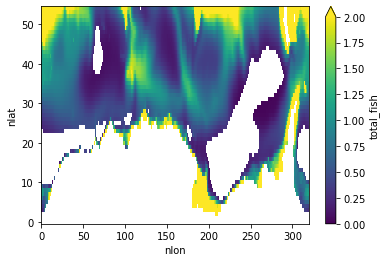

In [40]:
thres_totfish = ds_end.total_fish.where(ds_start.total_fish>0.05)
thres_totfish.plot(vmin=0,vmax=2)

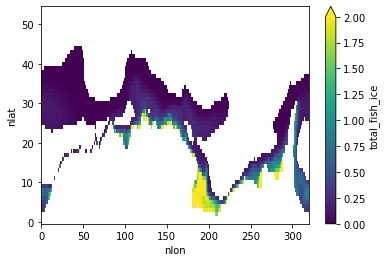

In [41]:
thres_icefish = ds_end.total_fish_ice.where(ds_start.total_fish_ice>0.05)
thres_icefish.plot(vmin=0,vmax=2)

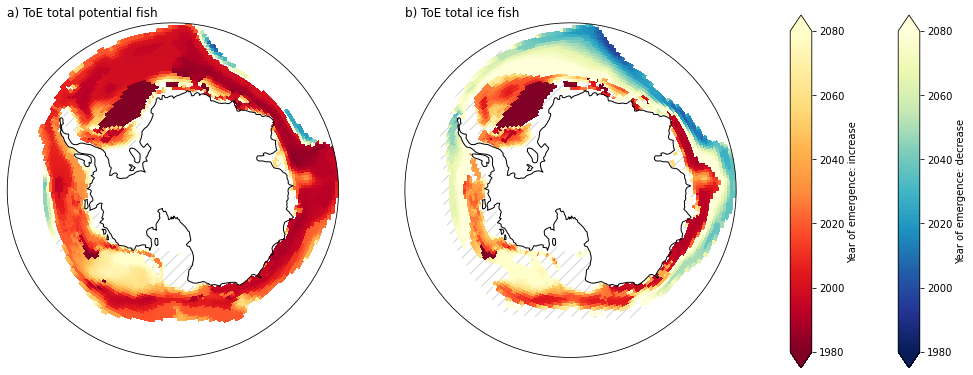

In [42]:
fig = plt.figure(figsize=(15,7))

######## ToE #################################################
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('a) ToE total potential fish', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ToE_up_fish.where(siz_mask==1))

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=1980,vmax=2080
                  )

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ToE_down_fish.where(siz_mask==1))

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=1980,vmax=2080
                  )

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('110m',linewidth=1)


######## ToE #################################################
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('b) ToE total ice fish', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ToE_up_icefish.where(siz_mask==1))

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=1980,vmax=2080
                  )

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ToE_down_icefish.where(siz_mask==1))

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=1980,vmax=2080
                  )

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('110m',linewidth=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc1, cax=cbar_ax,extend='both',label='Year of emergence: increase')


cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc2, cax=cbar_ax,extend='both',label='Year of emergence: decrease')

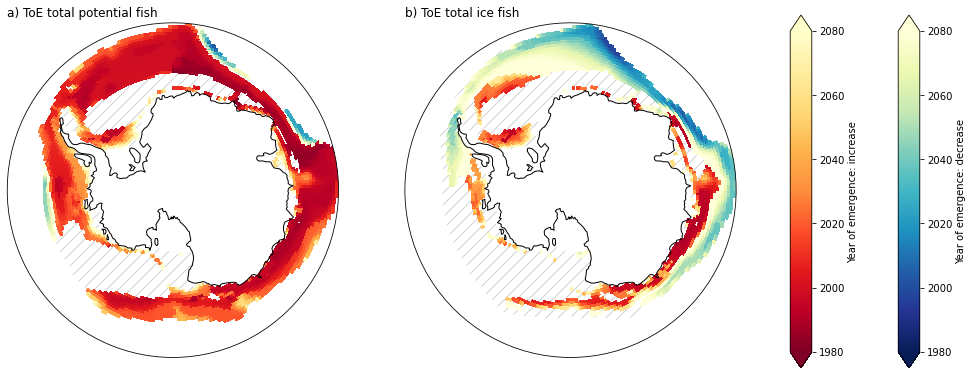

In [68]:
fig = plt.figure(figsize=(15,7))

######## ToE #################################################
ax = fig.add_subplot(1,2,1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('a) ToE total potential fish', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ToE_up_fish.where(siz_mask==1).where(thres_totfish>0))

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=1980,vmax=2080
                  )

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ToE_down_fish.where(siz_mask==1).where(thres_totfish>0))

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=1980,vmax=2080
                  )

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('110m',linewidth=1)


######## ToE #################################################
ax = fig.add_subplot(1,2,2, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax.set_title('b) ToE total ice fish', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, siz_mask)
pci=ax.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ToE_up_icefish.where(siz_mask==1).where(thres_icefish>0))

pc1 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=1980,vmax=2080
                  )

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ToE_down_icefish.where(siz_mask==1).where(thres_icefish>0))

pc2 = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=1980,vmax=2080
                  )

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

ax.coastlines('110m',linewidth=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc1, cax=cbar_ax,extend='both',label='Year of emergence: increase')


cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc2, cax=cbar_ax,extend='both',label='Year of emergence: decrease')

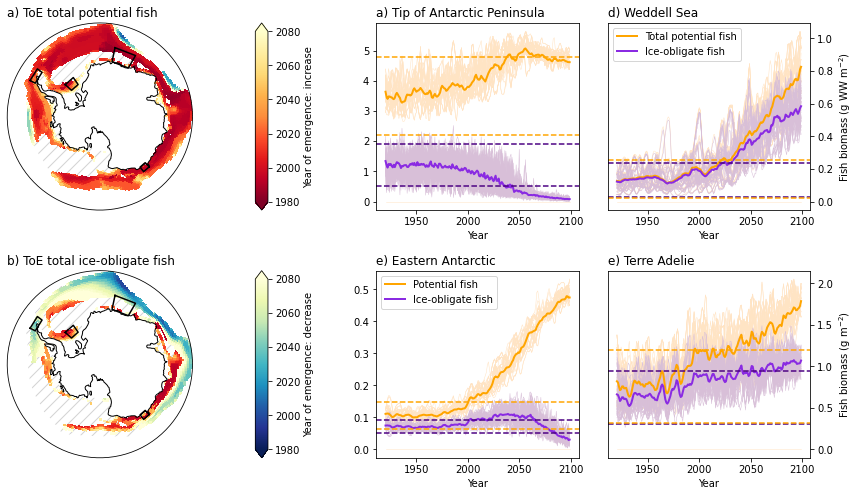

In [74]:
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(nrows=3, ncols=5, width_ratios=(1, 0.05, 0.2, 0.8, 0.8),height_ratios=(1,0.05,1))

prj =ccrs.SouthPolarStereo()

ax_map_tot = plt.subplot(gs[0, 0], projection=prj)
ax_map_if = plt.subplot(gs[2, 0], projection=prj)
ax_cb_up = plt.subplot(gs[0, 1])
ax_cb_down = plt.subplot(gs[2, 1])
ax_AP = plt.subplot(gs[0, 3])
ax_Wedd = plt.subplot(gs[0, 4])
ax_EAnt = plt.subplot(gs[2, 3])
ax_Adelie = plt.subplot(gs[2, 4])

box_color='black'
diff_cmap='bwr'
######################################################

ax_map_tot.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_map_tot.set_title('a) ToE total potential fish', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, siz_mask)
pci=ax_map_tot.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ToE_up_fish.where(siz_mask==1).where(thres_totfish>0))

pc1 = ax_map_tot.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=1980,vmax=2080)

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ToE_down_fish.where(siz_mask==1).where(thres_totfish>0))

pc2 = ax_map_tot.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=1980,vmax=2080)
ax_map_tot.set_boundary(circle, transform=ax_map_tot.transAxes)
ax_map_tot.coastlines('110m',linewidth=1)


# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax_map_tot.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax_map_tot.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())


lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax_map_tot.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box4_lonmin,box4_lonmax,box4_lonmax,box4_lonmin,box4_lonmin]
lat_pts = [box4_latmax,box4_latmax,box4_latmin,box4_latmin,box4_latmax]
ax_map_tot.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

# ############################

ax_map_if.set_extent([-180, 180, -90, -57], ccrs.PlateCarree())
ax_map_if.set_title('b) ToE total ice-obligate fish', loc='left')

### add hatch lines for the SIZ
plt.rcParams['hatch.color'] = 'lightgray'
lon, lat, field = utils.adjust_pop_grid(lons_x1, lats_x1, siz_mask)
pci=ax_map_if.contourf(lon, lat, field,transform=ccrs.PlateCarree(),hatches=['//'],colors='none')

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ToE_up_icefish.where(siz_mask==1).where(thres_icefish>0))

pc1 = ax_map_if.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlOrRd_r',
                   vmin=1980,vmax=2080)

lon,lat,field = utils.adjust_pop_grid(lons_x1, lats_x1, ToE_down_icefish.where(siz_mask==1).where(thres_icefish>0))

pc2 = ax_map_if.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),
                   cmap='YlGnBu_r',
                   vmin=1980,vmax=2080)

ax_map_if.set_boundary(circle, transform=ax_map_if.transAxes)
ax_map_if.coastlines('110m',linewidth=1)

# boxes
lon_pts = [box1_lonmin,box1_lonmax,box1_lonmax,box1_lonmin,box1_lonmin]
lat_pts = [box1_latmax,box1_latmax,box1_latmin,box1_latmin,box1_latmax]
ax_map_if.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box2_lonmin,box2_lonmax,box2_lonmax,box2_lonmin,box2_lonmin]
lat_pts = [box2_latmax,box2_latmax,box2_latmin,box2_latmin,box2_latmax]
ax_map_if.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())


lon_pts = [box3_lonmin,box3_lonmax,box3_lonmax,box3_lonmin,box3_lonmin]
lat_pts = [box3_latmax,box3_latmax,box3_latmin,box3_latmin,box3_latmax]
ax_map_if.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

lon_pts = [box4_lonmin,box4_lonmax,box4_lonmax,box4_lonmin,box4_lonmin]
lat_pts = [box4_latmax,box4_latmax,box4_latmin,box4_latmin,box4_latmax]
ax_map_if.plot(lon_pts, lat_pts, color=box_color, linewidth=1.5,transform=ccrs.PlateCarree())

######################################

cbar1 = fig.colorbar(pc1, cax=ax_cb_up, extend='both',label='Year of emergence: increase')
#ax_cb.text(1,0.1,'${\Delta}$ Fish biomass (g WW m$^{-2}$)', orientation='vertical')
cbar2 = fig.colorbar(pc2, cax=ax_cb_down, extend='both',label='Year of emergence: decrease')

#######################################

ax_AP.set_title('a) Tip of Antarctic Peninsula',loc='left')

for mem in np.arange(0,50,1):
    ax_AP.plot(years2, ts_AP['total_fish'].isel(member_id=mem,time=slice(70,250)), color='bisque', linewidth=0.5)
    

for mem in np.arange(0,50,1):
    ax_AP.plot(years2, ts_AP['total_fish_ice'].isel(member_id=mem,time=slice(70,250)), color='thistle', linewidth=0.5)
     
## plot means

ax_AP.plot(years2, ts_AP['total_fish'].mean(dim='member_id').isel(time=slice(70,250)), color='orange', linewidth=2, label='Total fish')
ax_AP.plot(years2, ts_AP['total_fish_ice'].mean(dim='member_id').isel(time=slice(70,250)), color='blueviolet', linewidth=2, label='Total ice-ob fish')

mean = ts_AP['total_fish_ice'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_AP['total_fish_ice'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='indigo')
ax_AP.axhline(mean+2*std, color='indigo',linestyle='--')
ax_AP.axhline(mean-2*std, color='indigo',linestyle='--')

mean = ts_AP['total_fish'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_AP['total_fish'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='orange')
ax_AP.axhline(mean+2*std, color='orange',linestyle='--')
ax_AP.axhline(mean-2*std, color='orange',linestyle='--')

ax_AP.set(xlabel='Year') #,ylabel='Fish biomass (g m$^{-2}$)');
#ax.set_ylim(0,1.6)
#ax.legend()


# ######################################################

ax_Wedd.set_title('d) Weddell Sea',loc='left')

for mem in np.arange(0,50,1):
    ax_Wedd.plot(years2, ts_Wedd['total_fish'].isel(member_id=mem,time=slice(70,250)), color='bisque', linewidth=0.5)
    

for mem in np.arange(0,50,1):
    ax_Wedd.plot(years2, ts_Wedd['total_fish_ice'].isel(member_id=mem,time=slice(70,250)), color='thistle', linewidth=0.5)
     
## plot means

ax_Wedd.plot(years2, ts_Wedd['total_fish'].mean(dim='member_id').isel(time=slice(70,250)), color='orange', linewidth=2, label='Total potential fish')
ax_Wedd.plot(years2, ts_Wedd['total_fish_ice'].mean(dim='member_id').isel(time=slice(70,250)), color='blueviolet', linewidth=2, label='Ice-obligate fish')

mean = ts_Wedd['total_fish_ice'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_Wedd['total_fish_ice'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='indigo')
ax_Wedd.axhline(mean+2*std, color='indigo',linestyle='--')
ax_Wedd.axhline(mean-2*std, color='indigo',linestyle='--')

mean = ts_Wedd['total_fish'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_Wedd['total_fish'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='orange')
ax_Wedd.axhline(mean+2*std, color='orange',linestyle='--')
ax_Wedd.axhline(mean-2*std, color='orange',linestyle='--')

ax_Wedd.set(xlabel='Year',ylabel='Fish biomass (g WW m$^{-2}$)');
#ax.set_ylim(0,1.6)
#ax.legend()
ax_Wedd.tick_params(top=False, labeltop=False, 
               bottom=True, labelbottom=True, 
               right=True, labelright=True,
               left=False, labelleft=False)
ax_Wedd.yaxis.set_label_position("right")
ax_Wedd.legend()
######################################################

ax_EAnt.set_title('e) Eastern Antarctic',loc='left')

for mem in np.arange(0,50,1):
    ax_EAnt.plot(years2, ts_EAnt['total_fish'].isel(member_id=mem,time=slice(70,250)), color='bisque', linewidth=0.5)
    

for mem in np.arange(0,50,1):
    ax_EAnt.plot(years2, ts_EAnt['total_fish_ice'].isel(member_id=mem,time=slice(70,250)), color='thistle', linewidth=0.5)
     
## plot means

ax_EAnt.plot(years2, ts_EAnt['total_fish'].mean(dim='member_id').isel(time=slice(70,250)), color='orange', linewidth=2, label='Potential fish')
ax_EAnt.plot(years2, ts_EAnt['total_fish_ice'].mean(dim='member_id').isel(time=slice(70,250)), color='blueviolet', linewidth=2, label='Ice-obligate fish')

mean = ts_EAnt['total_fish_ice'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_EAnt['total_fish_ice'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='indigo')
ax_EAnt.axhline(mean+2*std, color='indigo',linestyle='--')
ax_EAnt.axhline(mean-2*std, color='indigo',linestyle='--')

mean = ts_EAnt['total_fish'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_EAnt['total_fish'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='orange')
ax_EAnt.axhline(mean+2*std, color='orange',linestyle='--')
ax_EAnt.axhline(mean-2*std, color='orange',linestyle='--')

ax_EAnt.set(xlabel='Year') #,ylabel='Fish biomass (g m$^{-2}$)');
#ax.set_ylim(0,1.6)
ax_EAnt.legend() #bbox_to_anchor=(1.2, 0.4), loc='lower left')


######################################################

ax_Adelie.set_title('e) Terre Adelie',loc='left')

for mem in np.arange(0,50,1):
    ax_Adelie.plot(years2, ts_Adelie['total_fish'].isel(member_id=mem,time=slice(70,250)), color='bisque', linewidth=0.5)
    

for mem in np.arange(0,50,1):
    ax_Adelie.plot(years2, ts_Adelie['total_fish_ice'].isel(member_id=mem,time=slice(70,250)), color='thistle', linewidth=0.5)
     
## plot means

ax_Adelie.plot(years2, ts_Adelie['total_fish'].mean(dim='member_id').isel(time=slice(70,250)), color='orange', linewidth=2, label='Total potential fish')
ax_Adelie.plot(years2, ts_Adelie['total_fish_ice'].mean(dim='member_id').isel(time=slice(70,250)), color='blueviolet', linewidth=2, label='Ice-obligate fish')

mean = ts_Adelie['total_fish_ice'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_Adelie['total_fish_ice'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='indigo')
ax_Adelie.axhline(mean+2*std, color='indigo',linestyle='--')
ax_Adelie.axhline(mean-2*std, color='indigo',linestyle='--')

mean = ts_Adelie['total_fish'].isel(time=slice(70,100)).mean(dim=('time','member_id')).values
std = ts_Adelie['total_fish'].isel(time=slice(70,100)).std(dim=('time','member_id')).values
#ax.axhline(mean, color='orange')
ax_Adelie.axhline(mean+2*std, color='orange',linestyle='--')
ax_Adelie.axhline(mean-2*std, color='orange',linestyle='--')

ax_Adelie.set(xlabel='Year',ylabel='Fish biomass (g m$^{-2}$)');
#ax.set_ylim(0,1.6)
#ax_Adelie.legend(bbox_to_anchor=(1.2, 0.4), loc='lower left')
ax_Adelie.tick_params(top=False, labeltop=False, 
               bottom=True, labelbottom=True, 
               right=True, labelright=True,
               left=False, labelleft=False)
ax_Adelie.yaxis.set_label_position("right")


fig.savefig('/glade/work/kristenk/figs/Figure_fish_ToE.png', bbox_inches='tight', dpi=300, format='png');
